### Introduction to Text Mining
## Frequency Analysis
(c) Nuno Antonio 2019-2021

### Initial setup

In [4]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [5]:
# Load dataset
dtypes = {'RevID':'category','Source':'category','HotelID':'category',
  'HotelType':'category','HotelStars':'category','ObsDateGlobalRating':'float64',
  'Language':'category','RevUserName':'category','RevUserLocation':'category','RevOverallRating':'float64'}
ds = pd.DataFrame(pd.read_csv("HotelOnlineReviews.txt",sep="|", 
  error_bad_lines=False, dtype=dtypes, decimal=',', index_col='RevID'))

b'Skipping line 12799: expected 21 fields, saw 23\n'
b'Skipping line 37247: expected 21 fields, saw 22\n'


In [6]:
# Drop non-Portuguese reviews
ds = ds.drop(ds[ds.Language!='Portuguese'].index)

### Functions

In [7]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    cleanedText = []
    for x in (rawText[:]): 
        
        # Remove HTML
        if removeHTML:
            procText = BeautifulSoup(x,'html.parser').get_text()

         # Remove punctuation and other special characters
        if len(charsToRemove)>0:
            procText = re.sub(charsToRemove,' ',procText)

        # Remove numbers
        if removeNumbers:
            procText = re.sub(r'\d+',' ',procText)

        # Remove line breaks
        if removeLineBreaks:
            procText = procText.replace('\n',' ').replace('\r', '')

        # Remove special characters
        if len(specialCharsToRemove)>0:
            procText = re.sub(specialCharsToRemove,' ',procText)

        # Normalize to lower case
        if convertToLower:
            procText = procText.lower() 

        # Replace multiple consecutive spaces with just one space
        if removeConsecutiveSpaces:
            procText = re.sub(' +', ' ', procText)

        # If there is a text, add it to the clean text         
        if procText != '':
            cleanedText.append(procText)
    return cleanedText

In [8]:
# Tokenize texts
def tokenize_words(texts):
    words_new = []
    for w in (texts[:]):
        w_token = word_tokenize(w)
        if w_token != '':
            words_new.append(w_token)
    return words_new

In [9]:
# Stemm texts
def stemming(words):
    procText = []
    for w in (words[:]):
        stemmed_word = [snowball.stem(x) for x in (w[:])]
        procText.append(stemmed_word)
    return procText

In [10]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1): 
    vec = CountVectorizer(max_df=0.8, stop_words=stop_words,ngram_range=(nGrams,nGrams), max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Analysis

In [11]:
# Create a dataframe with only the description
processedReviews =  pd.DataFrame(data=textPreProcess(ds.RevDescription), index=ds.index, columns=['PreProcessedText']) 

In [12]:
# Tokenize text
processedReviews['Words'] =  tokenize_words(processedReviews['PreProcessedText'])

In [13]:
# Compute terms frequency distribution
from nltk.probability import FreqDist
fdist = FreqDist()
for review in processedReviews.Words:
  for term in review:
    fdist[term]+=1

In [14]:
# Transform results to a sorted dataframe
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [15]:
# Top 15
df_fdist.head(15)

,Frequency
Term,
e,13788
de,12375
a,10322
o,10169
do,6288
da,6145
muito,5796
que,5581
hotel,5284


In [16]:
# Low 15
df_fdist.tail(15)

,Frequency
Term,
pontar,1
conformidade,1
men,1
sabado,1
acomodacao,1
historica,1
almocar,1
destincao,1
gerar,1


In [17]:
# Remove stopwords and re-explore results
from nltk.corpus import stopwords
stop_words = set(stopwords.words('portuguese'))
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]
df_fdist.head(15)

,Frequency
Term,
hotel,5284
quarto,4196
localização,3152
quartos,2347
pequeno,2307
bom,2235
excelente,2164
café,2101
bem,2009


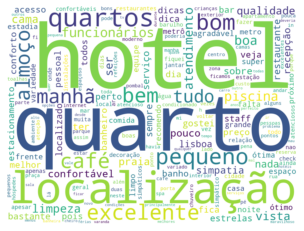

In [20]:
# Create a Word Cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width=1200, height=900, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The word cloud shows some words have the same origin, such as "quarto" and "quartos". Let's create a stemmed version of the word cloud

In [21]:
# Create a stemmed version of the words to normalize the Lexicon
# Import package
from nltk.stem import SnowballStemmer

In [22]:
# Check languages supported
print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [23]:
# Do stemming
snowball = SnowballStemmer("portuguese")
# Create a new column for stemm words
processedReviews['StemmedWords'] = stemming(processedReviews['Words'])

In [24]:
# Calculate frequency distributions of the stemmed words
fdist = FreqDist()
for review in processedReviews.StemmedWords:
  for term in review:
    fdist[term]+=1

# Create the sorted dataframe and sort it
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [25]:
# Remove the stopwords
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)] 

(-0.5, 1199.5, 899.5, -0.5)

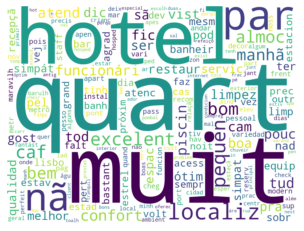

In [27]:
# Plot a new wordcloud with the stemmed words
wordcloud = WordCloud(width=1200, height=900, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

The word cloud is now different. For example, "Quart" (room) is now more frequent than "hotel".

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

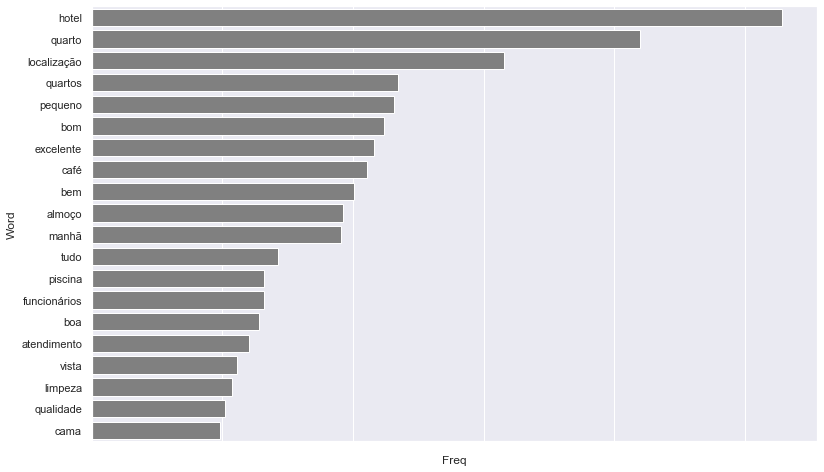

In [28]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=1)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

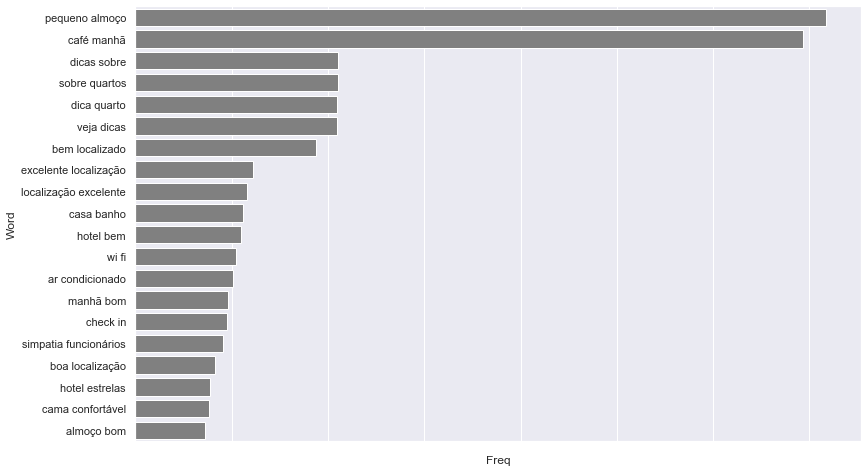

In [29]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=2)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

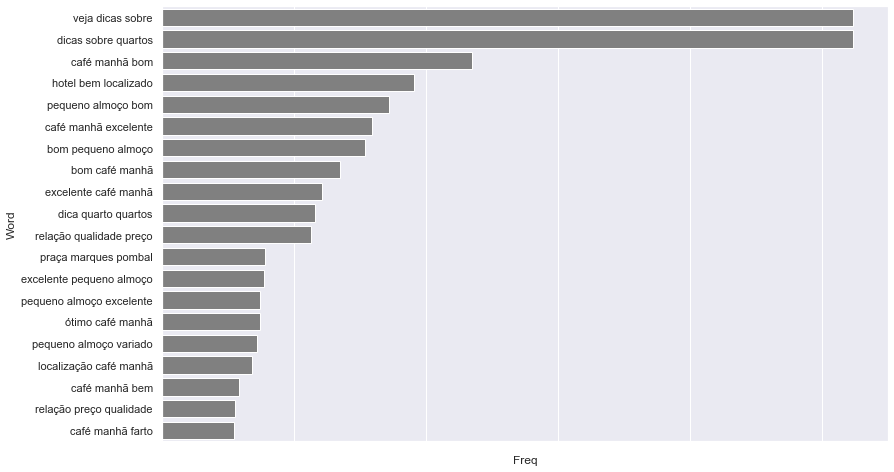

In [30]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=3)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="grey")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

"Veja dicas sobre" and "dicas sobre quartos" is text added to the desciption by Tripadvisor to lead users to read more about the hotel. Therefore, this text should be removed from the description in the preprocessing phase.